## Net Basin Runoff–OGGM

This notebook is designed to process and plot runoff outputs of OGGM by basin.

Last Updated: 5 June 2023 | FFW

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import os
import xarray as xr

In [80]:
#All of the climate models used
modelnames = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'CMCC-CM2-SR5','EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
               'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM', 'TaiESM1']

SSPs = ['ssp126','ssp245','ssp370','ssp585'] #SSPs in used in GloGEM and PyGEM--OGGM actually has 8
which_ssp = SSPs[0]

alpine_basins = {'RHINE': '6242',
                 'RHONE': '6243',
                 'PO': '6241',
                 'DANUBE':'6202'} ## GRDC Major River Basin identifiers for the 4 alpine basins we can study

test_basin = alpine_basins['RHINE'] 

#Generic filepath to navigate to Drive folder 
fpathOG = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/OGGM Outputs/'


In [81]:
import json
def select_glaciers_json(basin='all'):
    '''
    Select glaciers within a basin by MRBID from a json-file,
    which is stored in the data directory.

    Args:
    -----
    basin: str
        String of MRBID or 'all'.

    Returns:
    --------
    If basin is 'all' a list of all relevant glaciers is returned, for
    initiating glacier simulations. If basin is a MRBID the list of glaciers
    within that basin is returned.
    
    Copy of a function written by Erik Holmgren (2022) in holmgren_gha.utils
    '''

    # fpath = './data/rgi_ids_per_basin.json'
    fpath = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/rgi_ids_per_basin.json'  
    with open(fpath) as f:
        basin_dict = json.load(f)

    if basin.lower() != 'all':
        glacier_list = basin_dict[basin]
    else:
        glacier_list = list(itertools.chain.from_iterable(basin_dict.values()))

    return glacier_list

In [82]:
#Creating list of glaciers located within a basin using above function
basin_gls = {}
for basin, code in alpine_basins.items():
    basin_gls[basin] = select_glaciers_json(code)

In [131]:
#Loading in just one basin
test_basin = alpine_basins['RHINE'] 
fpath_oggm = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/OGGM Outputs/lschuster/{}'.format(test_basin)
with xr.open_mfdataset('{}/*.nc'.format(fpath_oggm)) as ds:
    ds = ds.runoff.load()

In [132]:
#Looping through all basins
rf_ds = {}
for basin, code in alpine_basins.items():
    fpath_basin = 'lschuster/{}'.format(code)
    with xr.open_mfdataset(f'{fpathOG + fpath_basin}/*.nc') as ds:
        ds = ds.runoff.load()
    rf_ds[basin] = ds

In [85]:
#Summing individual glacier runoff into basin totals and converting kg to km^3
basin_rf_OG = {}
for basin, code in alpine_basins.items():
    basin_rf_OG[basin] = rf_ds[basin].sum(dim = 'rgi_id') * 1e-12

In [86]:
#creating dict of GloPy format
basins = ['RHINE', 'RHONE', 'PO', 'DANUBE']
basin_sums_OG = {}
for s, SSP in enumerate(SSPs):
    which_ssp = SSPs[s]
    basin_sums_OG[which_ssp] = {}
    for b, basin in enumerate(basins):
        basin_sums_OG[which_ssp][basin] = basin_rf_OG[basin].sel(scenario = which_ssp)

In [110]:
#Plotting it looks like some GCMs contain all-zero values
basin_sums_OG['ssp126']['DANUBE'][14]

# CMCC-CM2-SR5 & TaiESM1 only hold values for ssp585
#Dropping these is proving trick, going to deal with this just by plotting slices

<xarray.DataArray 'runoff' (time: 101)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
  * time             (time) float64 2e+03 2.001e+03 ... 2.099e+03 2.1e+03
    scenario         <U6 'ssp126'
    gcm              <U7 'TaiESM1'
    hydro_year       (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    hydro_month      (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
    calendar_year    (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    calendar_month   (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    bias_correction  <U12 'bc_2000_2019'

Text(-1.43, 4.72, 'Rhine River Basin                   Rhone River Basin                      Po River Basin                   Danube River Basin')

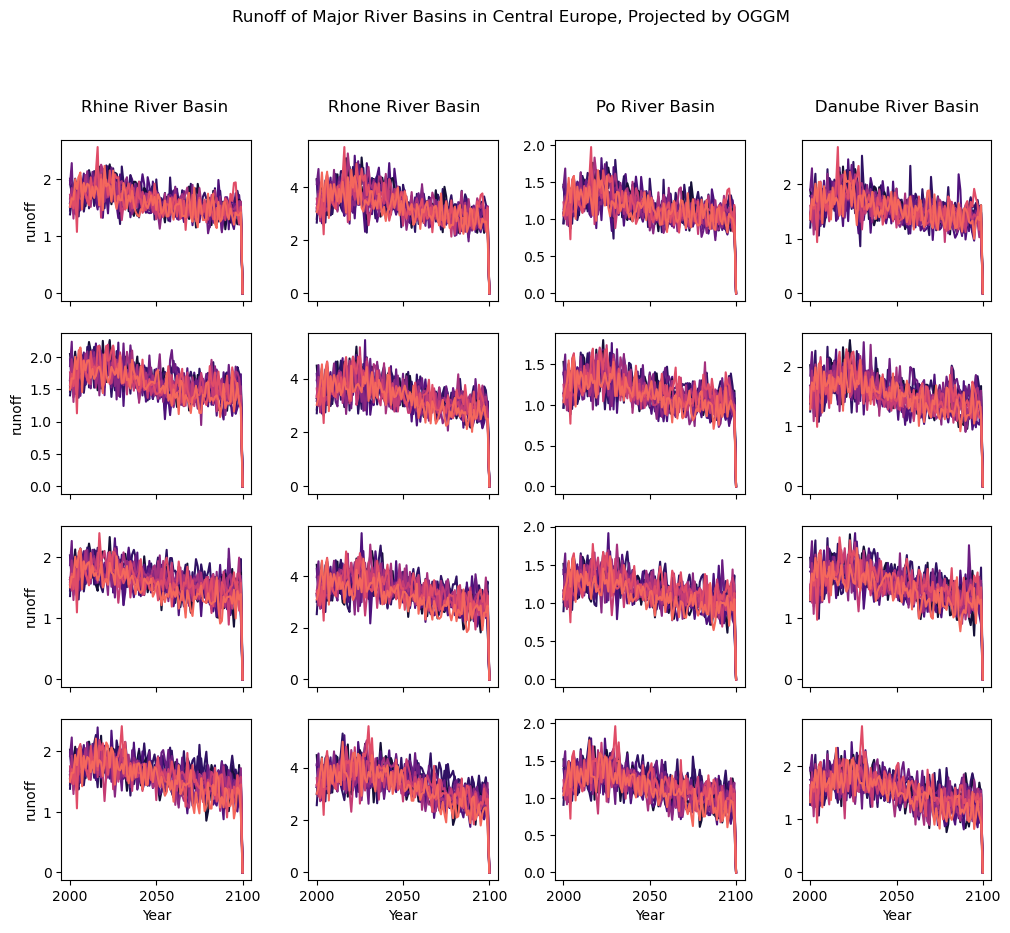

In [133]:
#Very rough plot to look at results
from cycler import cycler

scenarios = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
basins = ['RHINE', 'RHONE', 'PO','DANUBE']

#Creating color scheme
color_map = plt.colormaps['magma']
line_colors = color_map(np.linspace(0.1, 0.9, num = 12))
custom_cycler = cycler(color = line_colors)

#Plotting all data
fig, axs = plt.subplots(len(scenarios), 4, figsize=(12, 10), sharex=True)
for s, SSP in enumerate(scenarios):
    which_ssp = SSPs[s]
    for b, basin in enumerate(basins):
        basin_sums_OG[which_ssp][basin][0:3].plot(hue= 'gcm', ax=axs[s, b], color=axs[s, b].set_prop_cycle(custom_cycler), add_legend=False)
        basin_sums_OG[which_ssp][basin][5:-1].plot(hue= 'gcm', ax=axs[s, b], color=axs[s, b].set_prop_cycle(custom_cycler), add_legend=False)
        if s == 3:
            for sub_b in range(4):  # Use a different variable name for the inner loop
                axs[s, sub_b].set_xlabel('Year')
        else:
            axs[s, b].set_xlabel(None)
        if b == 0:
            if sub_s == 2:  # Use a different variable name for the inner loop
                axs[sub_s, b].set_ylabel(r'Rolling Mean Runoff $[km^3]$')
        else:
            axs[s, b].set_ylabel(None)
            
        axs[s, b].set_title("")  # Remove subplot titles

#Adding legend, titles, etc       
#axs[0,0].legend(['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8',
               #'INM-CM5-0', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM'],bbox_to_anchor=(4.96, 1.64), ncol=6)
plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.2)
plt.suptitle('Runoff of Major River Basins in Central Europe, Projected by OGGM')
plt.title('Rhine River Basin                   Rhone River Basin                      Po River Basin                   Danube River Basin', x=-1.43, y=4.72)